In [3]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime
import matplotlib.pyplot as plt
import numpy
from readSelfTrackerSheet import *
import difflib

In [4]:
sheet = RetrieveSpreadSheet()

In [10]:
 SetUpDates()

Please provide the begin date in "M/D/YYYY" format (ie 5/11/1989) to filter
	"all"	if you dont want to filter:3/15/2018
Please provide the latest date in "M/D/YYYY" format (ie 5/11/2018) to filter
	"today"	if you dont want to filter:today


In [6]:
GetListOfTraineeObjects(sheet)

Please indicate in semicolon seperated format who the desired trainees are.

	ie "Gamboa,Allan";"Basior,Greg";...

	If all trainees are desired say:

	"all"

	Available Trainees are:

	Butts
	Vaughan
	Jack
	Warner
	Curnutt
	Rowlett
	Frye
	Helwig
	Garvey
	Pittman
	Griffin
	Perkins
	Jestes
all
Creating Object For butts
Creating Object For vaughan
Creating Object For jack
Creating Object For warner
Creating Object For curnutt
Creating Object For rowlett
Creating Object For frye
Creating Object For helwig
Creating Object For garvey
Creating Object For pittman
Creating Object For griffin
Creating Object For perkins
Creating Object For jestes


In [11]:
FilterTraineesDateRanges()

/root/PycharmProject/JQRSelfProgress/venv/lib/python3.5/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/root/PycharmProject/JQRSelfProgress/venv/lib/python3.5/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: invalid value encountered in true_divide
  c = (c.T/scale).T  # broadcast scale coefficients
/root/PycharmProject/JQRSelfProgress/readSelfTrackerSheet.py:162: RankWarning: Polyfit may be poorly conditioned
  coeff = numpy.polyfit(xvals, numpy.array(sumList(lineItems)), 1)
/root/PycharmProject/JQRSelfProgress/readSelfTrackerSheet.py:183: RankWarning: Polyfit may be poorly conditioned
  coeff = numpy.polyfit(xvals, numpy.array(sumList(compPercentages)), 1)


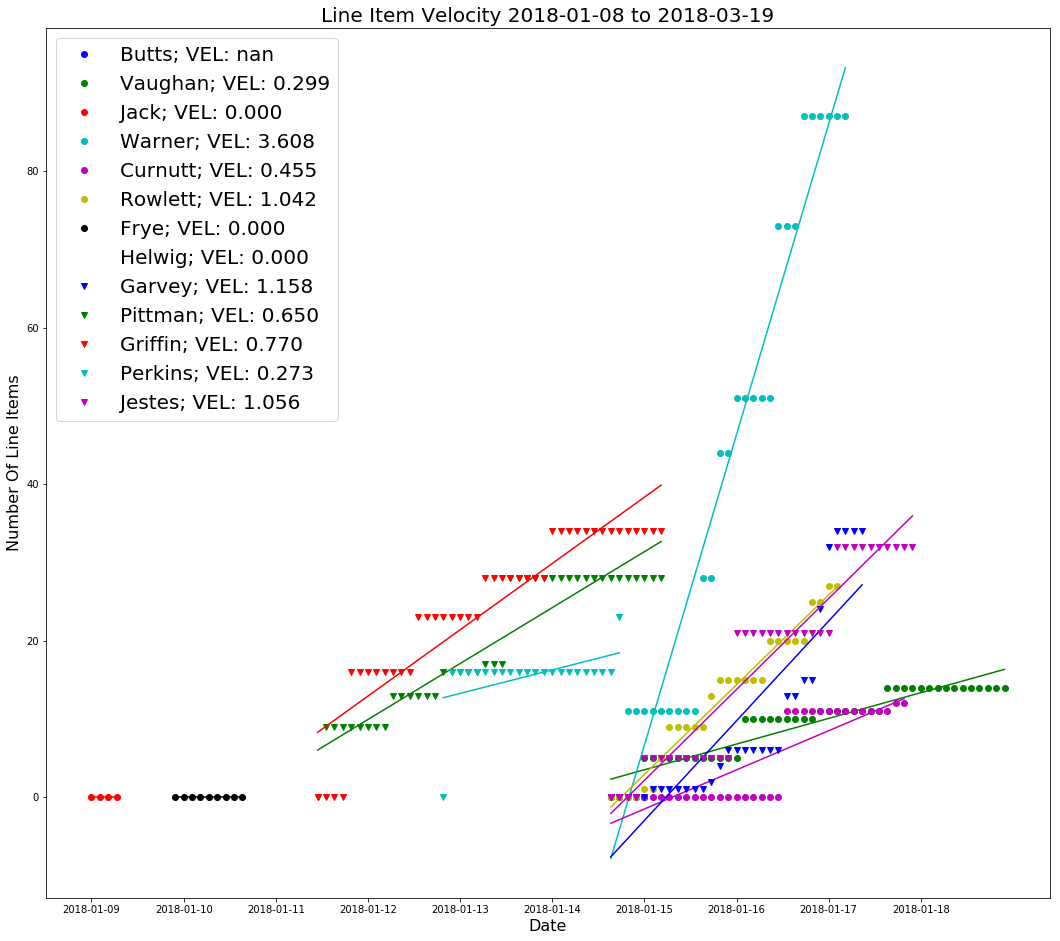

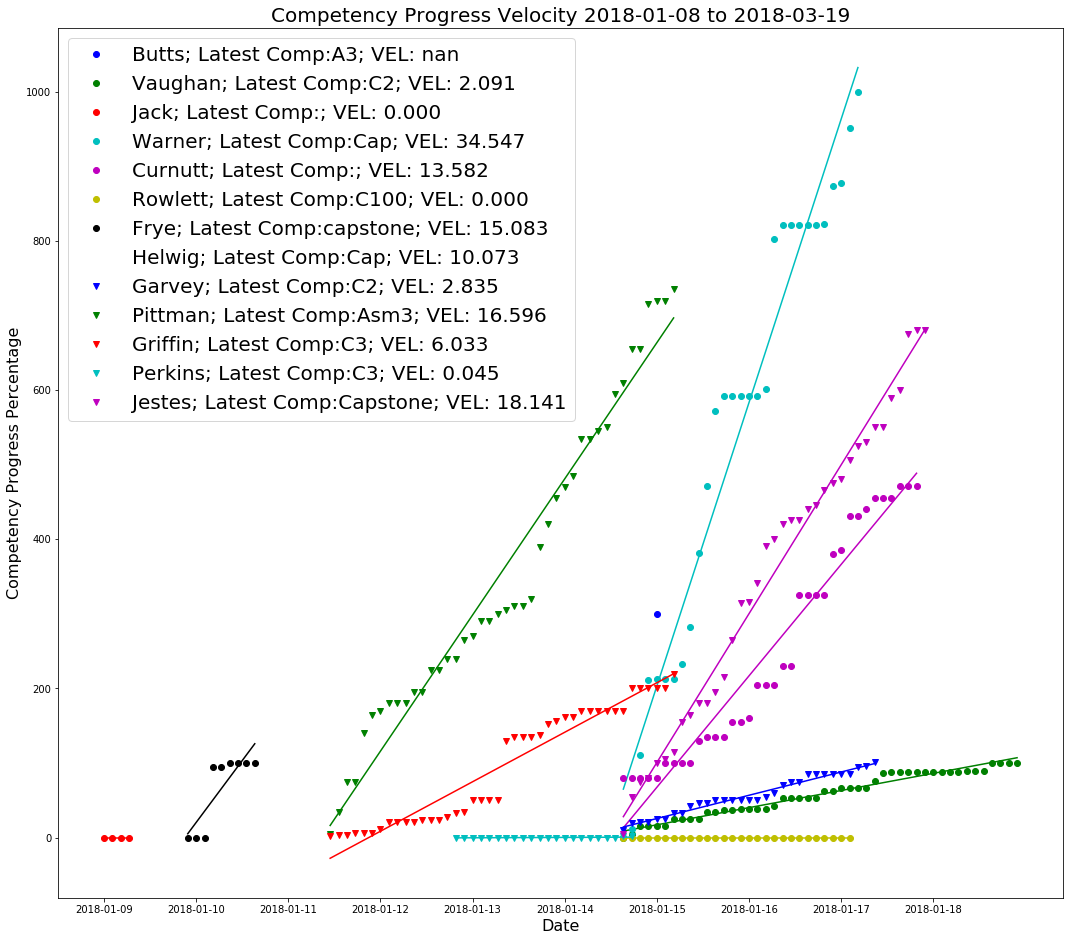

In [8]:
MakePlots()   

In [12]:
CreateTableOfVelocities()

2018-01-08 to 2018-03-19

Line Velocity ML:	Mean = nan	STD = nan
Comp Velocity ML:	Mean = nan	STD = nan
Line Velocity AVG:	Mean = 0.628	STD = 0.357
Comp Velocity AVG:	Mean = 44.946	STD = 96.629

      NAME          LINE ITEM       LINE ITEM     COMP PROGRESS   COMP PROGRESS    LINE ITEMS         COMPS     
                  VELOCITY ML    VELOCITY AVG   % VELOCITYM ML  % VELOCITY AVG     COMPLETED       COMPLETED   
     Butts            nan            0.000            nan           300.000            0               3       
    Vaughan          0.299           0.292           2.091           2.083             0               0       
    Curnutt          0.455           0.333           13.582          13.111            1               1       
    Rowlett          1.042           0.964           0.000           0.000             0               0       
    Garvey           1.158           1.097           2.835           3.258             7               0       
    Pittman         

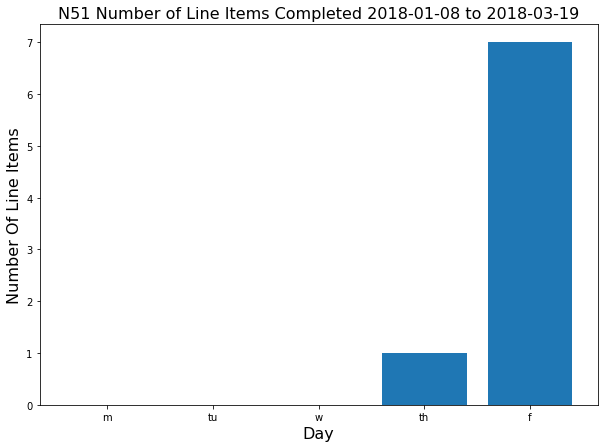

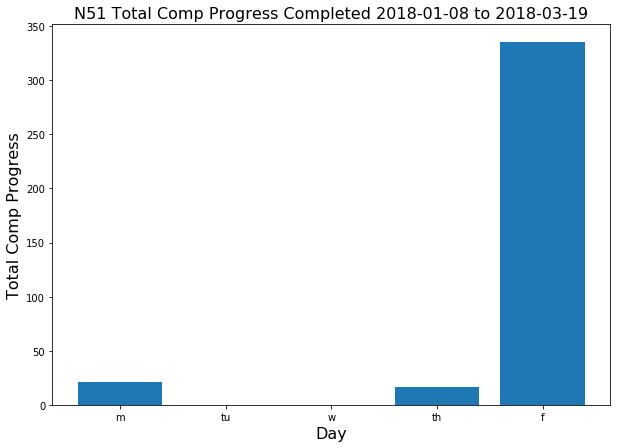

In [16]:
CreateDayOfWeekDistributions()

In [8]:
UpdateJQRTracker(selfTrackerSheetName='JQR Self Progress',
                     historicalTrackerSheetName='Historical Training Tracker',
                     targetSheetName='Training Tracker.xlsx')

Creating count object for  Copy of BLANK.
Could not find Copy of BLANK in historical sheet.
Could not find Copy of BLANK in historical sheet.
Updating Copy of BLANK.

Could not find Copy of BLANK in target sheet.
Creating count object for  Butts.
Updating Butts.

Creating count object for  Vaughan.
Updating Vaughan.

Creating count object for  Jack.
Could not find Jack in historical sheet.
Could not find Jack in historical sheet.
Updating Jack.

Could not find Jack in target sheet.
Creating count object for  Warner.
Could not find Warner in historical sheet.
Could not find Warner in historical sheet.
Updating Warner.

Creating count object for  Curnutt.
PracticeComp1 is an invalid comp name.
PracticeComp2 is an invalid comp name.
Updating Curnutt.

Creating count object for  Rowlett.
Updating Rowlett.

Creating count object for  Frye.
Updating Frye.

Creating count object for  Helwig.
Updating Helwig.

Creating count object for  Garvey.
Updating Garvey.

Creating count object for  Pitt

In [13]:
testdate=datetime.datetime.min

In [14]:
testdate

datetime.datetime(1, 1, 1, 0, 0)

In [15]:
min(1, None)

TypeError: unorderable types: NoneType() < int()